In [42]:
import numpy as np
import pandas as pd
import seaborn as sn
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [43]:
#Fixed the CSV file to replace NA with None
df = pd.read_csv(r"C:\Users\sa952592\Documents\Python Scripts\Kaggle\comp1\train.csv")
test_df = pd.read_csv(r"C:\Users\sa952592\Documents\Python Scripts\Kaggle\comp1\test.csv")

test_df.head()



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [44]:
#Get the dummy variables for all features.
# 1 : Numerical : Fill with the mean values
# 2:  Categorical : 1) Replace NA with None, as NA has some meaning. 
#                      Like NA for parking will mean No parking and may effect SaleCost
#Rest all delete the rows

def clean_data(df):
    df['MasVnrType'].fillna("NoNe",inplace=True)
    df['MasVnrArea'].fillna(df['MasVnrArea'].mean(),inplace=True)
    df['BsmtFinSF2'].fillna(df['BsmtFinSF2'].mean(),inplace=True)
    df['BsmtUnfSF'].fillna(df['BsmtUnfSF'].mean(),inplace=True)
    df['TotalBsmtSF'].fillna(df['TotalBsmtSF'].mean(),inplace=True)
    df['BsmtFullBath'].fillna(df['BsmtFullBath'].mean(),inplace=True)
    df['BsmtHalfBath'].fillna(df['BsmtHalfBath'].mean(),inplace=True)
    df['LotFrontage'].fillna(df['LotFrontage'].mean(),inplace=True)
    df['Alley'].fillna("NoNe",inplace=True)
    df['FireplaceQu'].fillna("NoNe",inplace=True)
    df['GarageType'].fillna("NoNe",inplace=True)
    df['GarageYrBlt'].fillna("NoNe",inplace=True)
    df['GarageFinish'].fillna("NoNe",inplace=True)
    df['GarageQual'].fillna("NoNe",inplace=True)
    df['GarageCond'].fillna("NoNe",inplace=True)
    df['PoolQC'].fillna("NoNe",inplace=True)
    df['Fence'].fillna("NoNe",inplace=True)
    df['MiscFeature'].fillna("NoNe",inplace=True)
    df['GarageCars'].fillna(df['GarageCars'].mean(),inplace=True)
    df['GarageArea'].fillna(df['GarageArea'].mean(),inplace=True)
    #For rest of he variables we will drop the data
    df.dropna(axis=0,inplace=True)
    return df

def get_dummies(df):
    df = pd.get_dummies(df)
    return df


In [45]:
df = clean_data(df)
test_df = clean_data(test_df)
print(df.shape)
print(test_df.shape)

(1420, 81)
(1404, 80)


In [46]:
#convert the categorical variable by adding dummies
df = get_dummies(df)
test_df = get_dummies(test_df)

#Test to see if both the test & train data and same columns
print(df.shape)
print(test_df.shape)





(1420, 393)
(1404, 372)


In [47]:
#Since we have now figure out that train has more columns then test, 
#we can safely assume that no significant feature of the training set will be missing from test set.
#Else we need to get the test database updated.

#Now find the significant features, for the SalePrice
#Will Get the Pearson Correlation with Saleprice with below thresholds

pthreshhold = 0.3
nthreshhold = -0.3

def get_significant_features(df,feature='SalePrice'):
    Corr = pd.DataFrame(df.corr()[feature])
    Corr = Corr[(Corr >  pthreshhold) | (Corr <  nthreshhold ) ]
    #Drop all the not significant values.
    Corr = Corr.dropna()
    return Corr


In [48]:
train_corr = get_significant_features(df,'SalePrice')


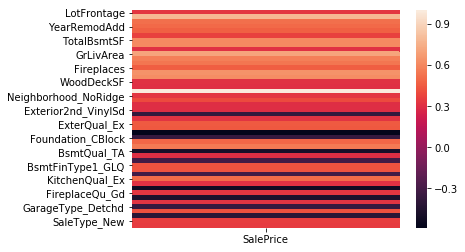

In [49]:
#Draw a heatmap of the correlation . 
sn.heatmap(train_corr)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


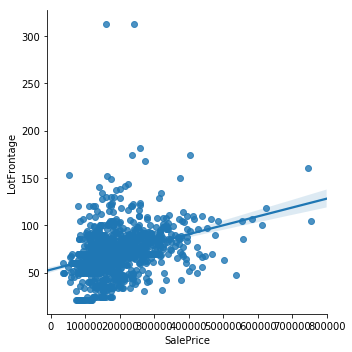

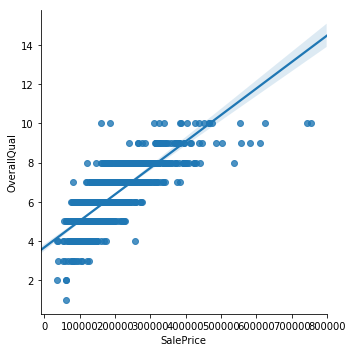

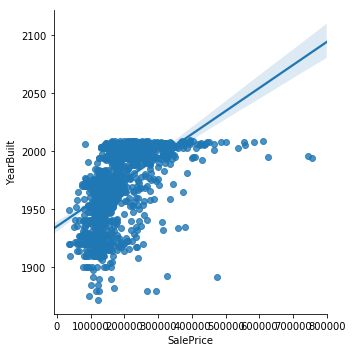

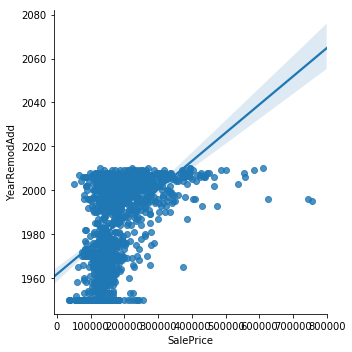

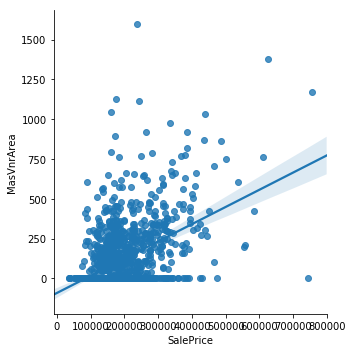

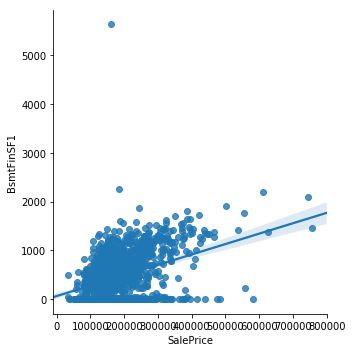

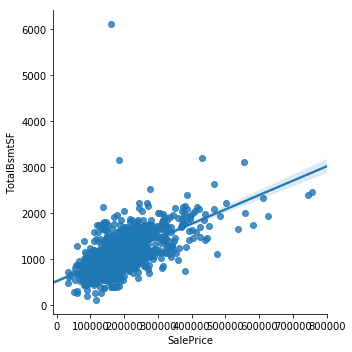

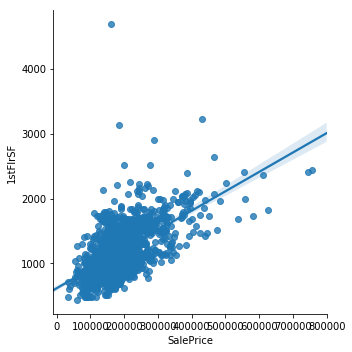

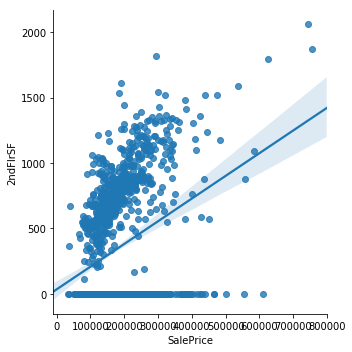

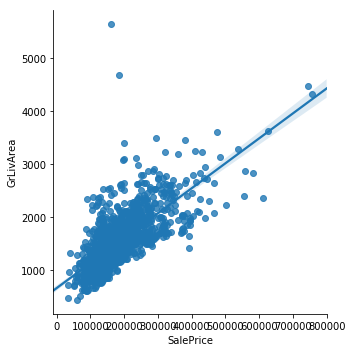

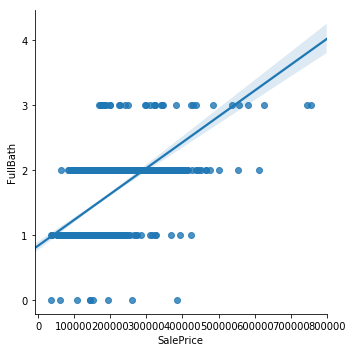

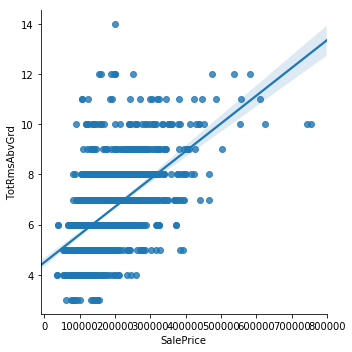

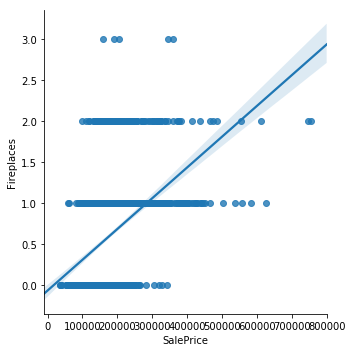

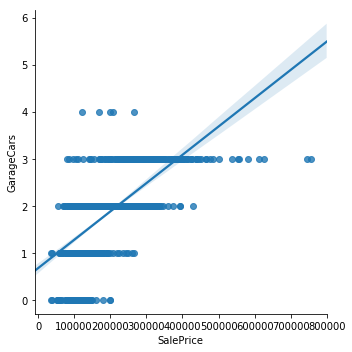

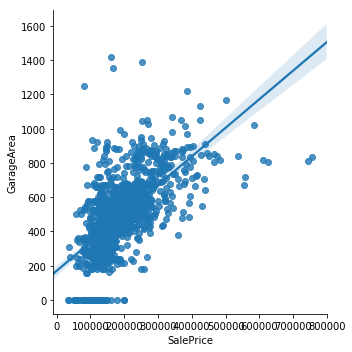

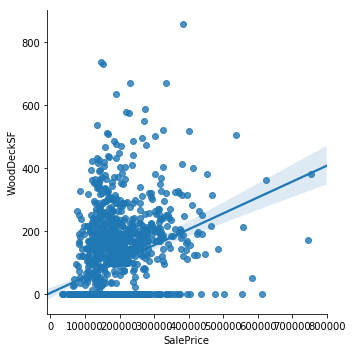

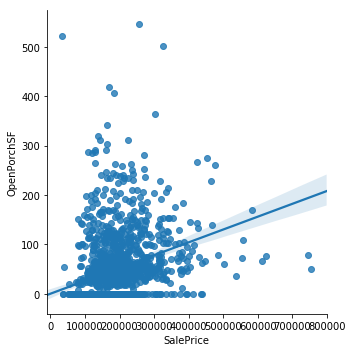

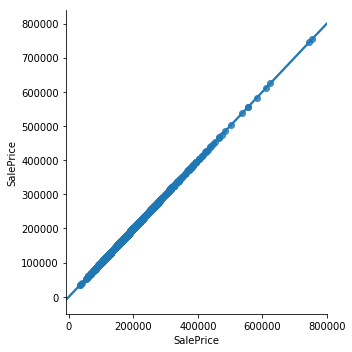

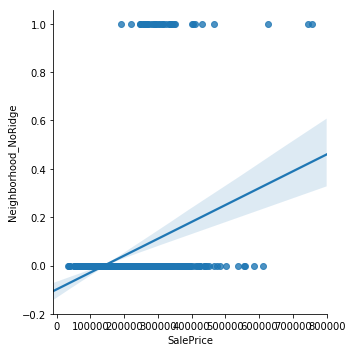

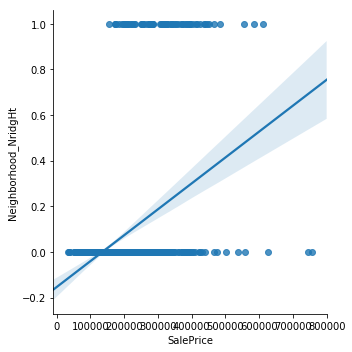

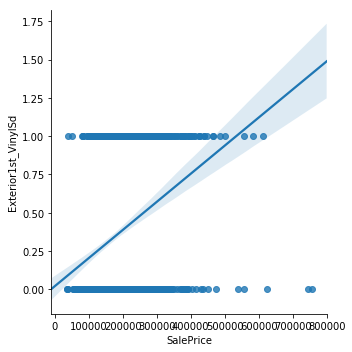

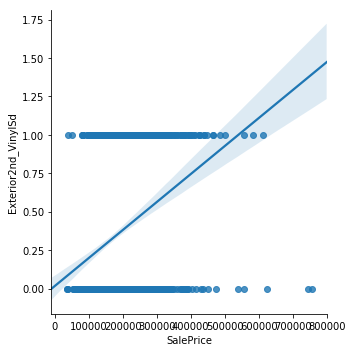

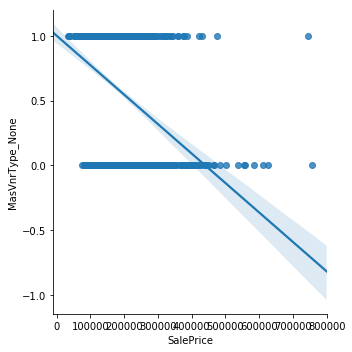

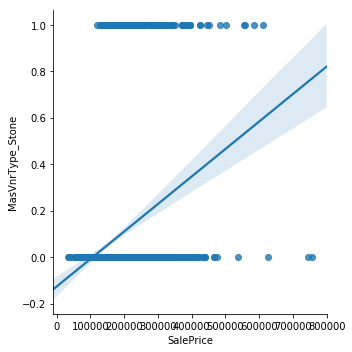

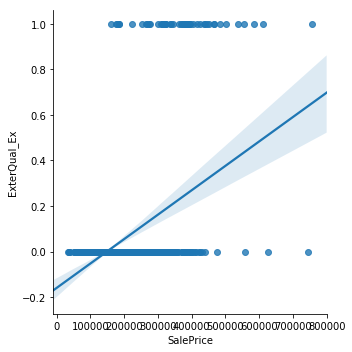

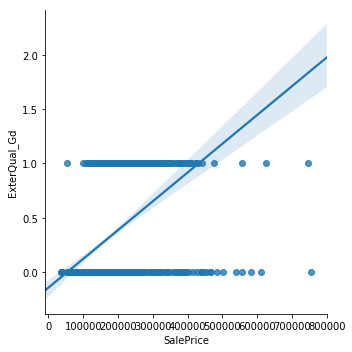

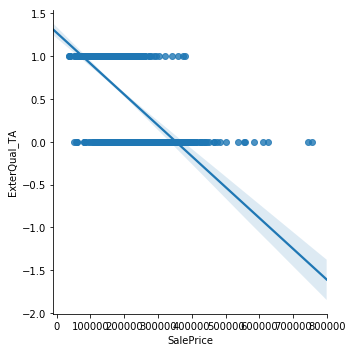

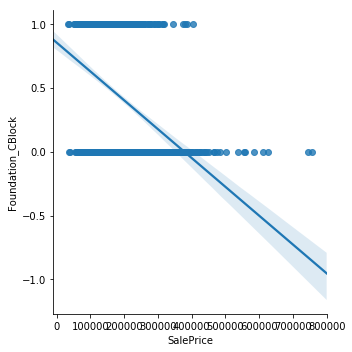

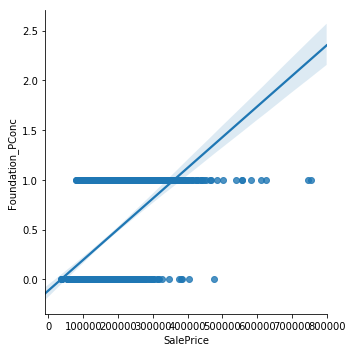

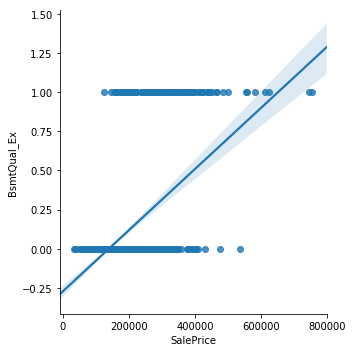

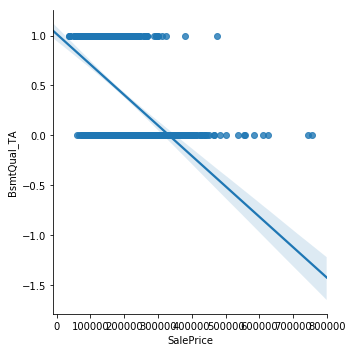

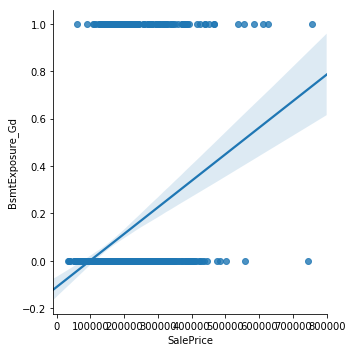

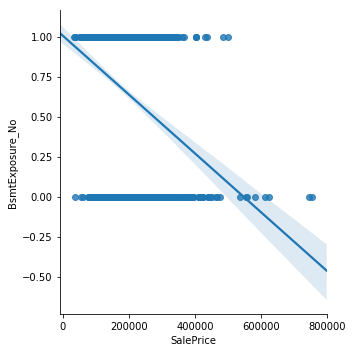

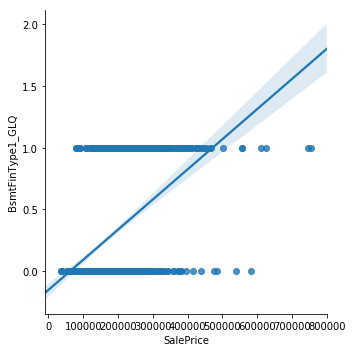

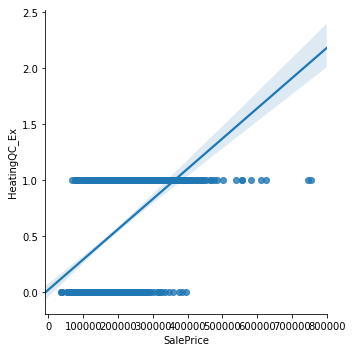

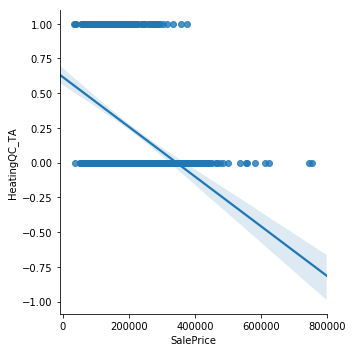

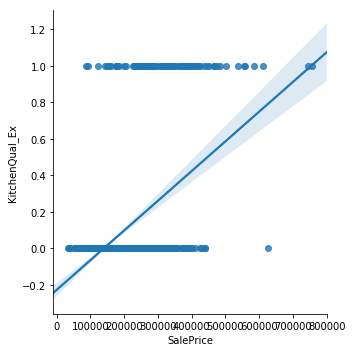

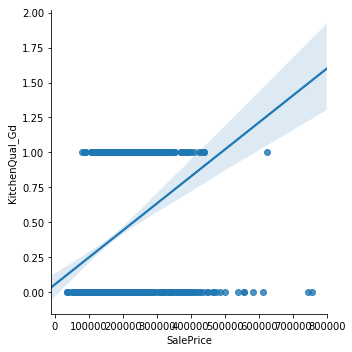

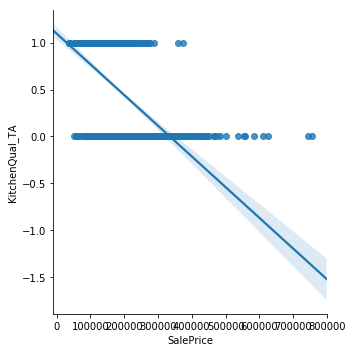

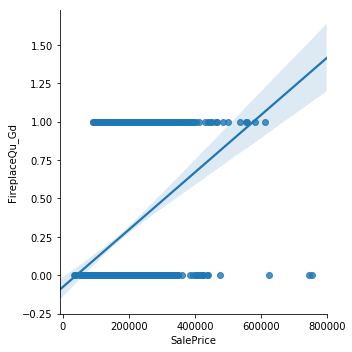

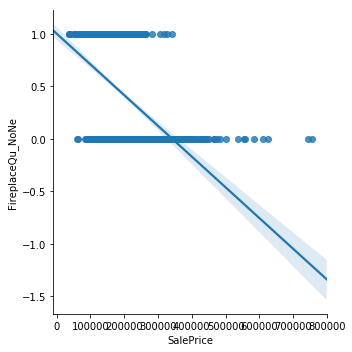

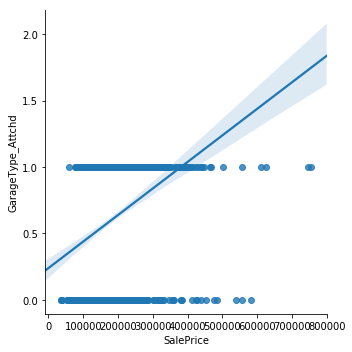

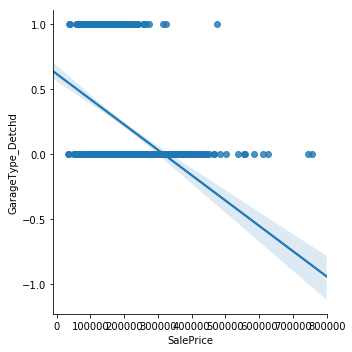

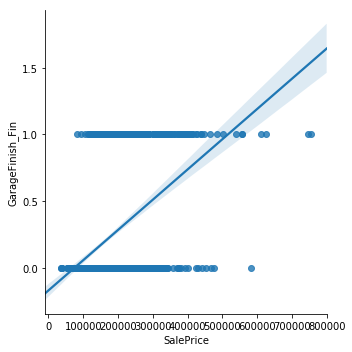

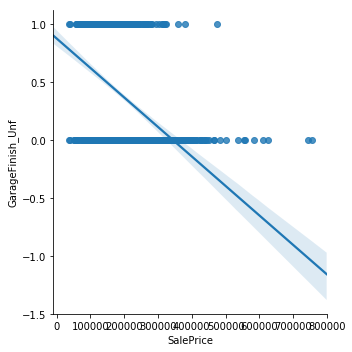

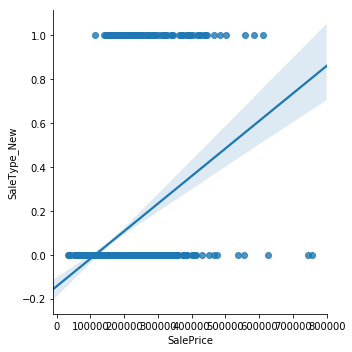

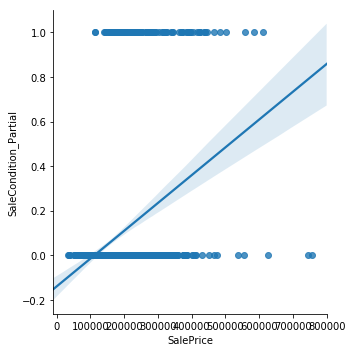

In [50]:
for item in train_corr.index:
    sn.lmplot(x ='SalePrice',y=item,data=df)



In [51]:
#Now lets move the Regression on the significant features
#Now lets start the regression model
#Extract the rigth set of features from df

Y = df['SalePrice']
df.drop('SalePrice',axis=1,inplace=True)


In [52]:
train_corr.drop('SalePrice',axis=0,inplace=True)


In [53]:
X = df[train_corr.index]
X = sm.add_constant(X)


In [54]:
def run_reg(X,Y):
    #Now lets start the regression model
    lreg = sm.OLS(Y,X)
    return lreg

In [55]:
def get_model(lreg,X,Y):
    feature_count=1
    count = -1
    while(feature_count !=0):
        count+= 1
        model = lreg.fit()
        pvalues = model.pvalues
        feature_count= len(pvalues[pvalues > 0.05] )
        if(feature_count != 0):
            pvalues = pvalues[pvalues < 0.05]
            pvalues.drop('const',axis=0,inplace=True)
            X = df[pvalues.index]
            X = sm.add_constant(X)
            lreg = run_reg(X,Y)
    return X, model

In [56]:
lreg = run_reg(X,Y)
X, model = get_model(lreg,X,Y)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     417.9
Date:                Tue, 26 Feb 2019   Prob (F-statistic):               0.00
Time:                        13:03:53   Log-Likelihood:                -16830.
No. Observations:                1420   AIC:                         3.369e+04
Df Residuals:                    1404   BIC:                         3.378e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -8.92e+05   1.06e+05     -8.383      0.000    -1.1e+06   -6.83e+05
OverallQual           1.843e+04   1077.754     17.097      0.000    1.63e+04    2.05e+04
YearRemodAdd           424.4369     54.702      7.759      0.000     317.131     531.743
MasVnrArea              28.8711      7.499      3.850      0.000      14.160      43.582
BsmtFinSF1              17.2982      2.285      7.570      0.000      12.816      21.781
TotRmsAbvGrd          9502.4736    658.616     14.428      0.000    8210.496    1.08e+04
Fireplaces            1.173e+04   1620.048      7.242      0.000    8554.981    1.49e+04
GarageCars            1.487e+04   1623.258      9.158      0.000    1.17e+04     1.8e+04
WoodDeckSF              27.0300      7.689      3.515      0.000      11.947      42.113
Neighborhood_NoRidge  6.277e+04   5955.462     10.541      0.000    5.11e+04    7.45e+04
Neighborhood_NridgHt  1.761e+04   4835.711      3.641      0.000    8119.828    2.71e+04
MasVnrType_None       9055.6207   2620.847      3.455      0.001    3914.424    1.42e+04
BsmtQual_Ex            3.12e+04   4279.878      7.291      0.000    2.28e+04    3.96e+04
BsmtExposure_Gd        1.99e+04   3642.339      5.463      0.000    1.28e+04     2.7e+04
BsmtExposure_No      -7627.1600   2261.290     -3.373      0.001   -1.21e+04   -3191.289
KitchenQual_Ex        3.273e+04   4422.054      7.401      0.000    2.41e+04    4.14e+04
==============================================================================
Omnibus:                      359.781   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21561.989
Skew:                          -0.131   Prob(JB):                         0.00
Kurtosis:                      22.088   Cond. No.                     2.40e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
y_predict = model.predict(X)
print(y_predict.shape,X.shape)

(1420,) (1420, 16)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     417.9
Date:                Tue, 26 Feb 2019   Prob (F-statistic):               0.00
Time:                        13:04:04   Log-Likelihood:                -16830.
No. Observations:                1420   AIC:                         3.369e+04
Df Residuals:                    1404   BIC:                         3.378e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -8.92e+05   1.06e+05     -8.383      0.000    -1.1e+06   -6.83e+05
OverallQual           1.843e+04   1077.754     17.097      0.000    1.63e+04    2.05e+04
YearRemodAdd           424.4369     54.702      7.759      0.000     317.131     531.743
MasVnrArea              28.8711      7.499      3.850      0.000      14.160      43.582
BsmtFinSF1              17.2982      2.285      7.570      0.000      12.816      21.781
TotRmsAbvGrd          9502.4736    658.616     14.428      0.000    8210.496    1.08e+04
Fireplaces            1.173e+04   1620.048      7.242      0.000    8554.981    1.49e+04
GarageCars            1.487e+04   1623.258      9.158      0.000    1.17e+04     1.8e+04
WoodDeckSF              27.0300      7.689      3.515      0.000      11.947      42.113
Neighborhood_NoRidge  6.277e+04   5955.462     10.541      0.000    5.11e+04    7.45e+04
Neighborhood_NridgHt  1.761e+04   4835.711      3.641      0.000    8119.828    2.71e+04
MasVnrType_None       9055.6207   2620.847      3.455      0.001    3914.424    1.42e+04
BsmtQual_Ex            3.12e+04   4279.878      7.291      0.000    2.28e+04    3.96e+04
BsmtExposure_Gd        1.99e+04   3642.339      5.463      0.000    1.28e+04     2.7e+04
BsmtExposure_No      -7627.1600   2261.290     -3.373      0.001   -1.21e+04   -3191.289
KitchenQual_Ex        3.273e+04   4422.054      7.401      0.000    2.41e+04    4.14e+04
==============================================================================
Omnibus:                      359.781   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21561.989
Skew:                          -0.131   Prob(JB):                         0.00
Kurtosis:                      22.088   Cond. No.                     2.40e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

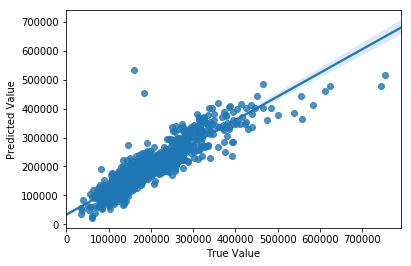

In [58]:
X['Predicted Value'] = y_predict
X['True Value'] = Y
sn.regplot(x='True Value',y='Predicted Value',data=X)
X.drop('Predicted Value',axis=1,inplace=True)
X.drop('True Value',axis=1,inplace=True)
pvalues_train = model.pvalues
model.summary()

In [59]:
# Let's see if Regularization will bring any benefits to the model
from sklearn.linear_model import Ridge 
def perfRidge(X,Y,alpha=0.01):
    lreg = Ridge(alpha)
    lreg.fit(X,Y)
    Y_predict = lreg.predict(X)
    return lreg

In [60]:
alphaVal = list([100,10,0.1,0.01,0.001])
R2 = list()
for alpha in alphaVal:
    lreg = perfRidge(X,Y,alpha)
    R2.append(lreg.score(X,Y))
#print all the values with different values of alpha    
R2
#It seems Regularization is not giving any benefits as R2 remains at 0.81699 which eas same as 0.817 without regularization

[0.8017737671687541,
 0.8159119342782142,
 0.8169989401956352,
 0.8169991160683282,
 0.816999117836293]

In [61]:
#Prepare the test data now
pvalues_train.drop('const',axis=0,inplace=True)
X_test = test_df[pvalues_train.index]
X_test = sm.add_constant(X_test)


In [62]:
#Run the Test data Now
Y_pred = model.predict(X_test)
pvalues_test = model.pvalues


In [63]:
Predict = pd.DataFrame({'Id': test_df.Id, 'SalePrice': Y_pred})

Predict.head()
Predict.to_csv('submission.csv')
